<a href="https://colab.research.google.com/github/marcusaxelsson1/Advanced_NN/blob/main/HWD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reservoir Computing Assignment

This assignment involves predicting time series data using the Lorenz system and reservoir computing, a type of recurrent neural network. Follow the steps outlined below to complete your tasks.

## Task 1: Generate Training Set

1. **Generate a training set of time series `x2(t)` by numerically solving Equation (4), with parameters:**
   - $ \sigma = 10 $
   - $ r = 28 $
   - $ b = \frac{8}{3} $

Reference for the task: Exercise 3.2 in *Nonlinear Time Series Analysis* by Kantz and Schreiber.

## Task 2: Setup and Train Reservoir

2. **Set up a reservoir as described in Equation (1) and train the output weights to minimize the energy function when predicting the Lorenz system.**

## Task 3: Train and Evaluate Two Reservoirs

3. **Train two reservoirs:**
   - One on the entire Lorenz system. $\sigma$
   - One on a single variable of the Lorenz system, say `x2`. For the single variable reservoir, only predict that variable.

   **Evaluate their prediction performance over a range of different values for the maximal singular value of the reservoir weight matrix `W`. Determine the upper and lower bounds of singular values that allow the reservoir to predict the time series in both cases.**

   **Discuss:**
   - The bounds observed.
   - Differences between the two cases.
   - Why these differences might appear.

   **Hint:** Plot the prediction performance versus the maximal singular value using a log-scale for the x-axis.

## Task 4: Evaluate Prediction Performance

4. **Evaluate how well the reservoir computer predicts the time series `x2(t)` and compare with standard methods.**
   - Determine the maximal Lyapunov exponent $ \lambda_1 $ by numerical simulation of Eq. (4) of the Lorenz system.
   - Check for how many Lyapunov times the time-series prediction works.
   - Plot the prediction error as a function of $ t\lambda_1 $.


In [ ]:
# Lorenz system
def lorenz_system(t, y, sigma=10, rho=28, beta=8/3):
    x1, x2, x3 = y
    return [-sigma * (x1 - x2), x1 * (rho - x3) - x2, x1 * x2 - beta * x3]

# Initial conditions and time span
y0 = [1.0, 1.0, 1.0]
t_span = [0, 200]
t_eval = np.linspace(t_span[0], t_span[1], 10000)

# Solving the system
sol = solve_ivp(lorenz_system, t_span, y0, t_eval=t_eval)
x2 = sol.y[1]



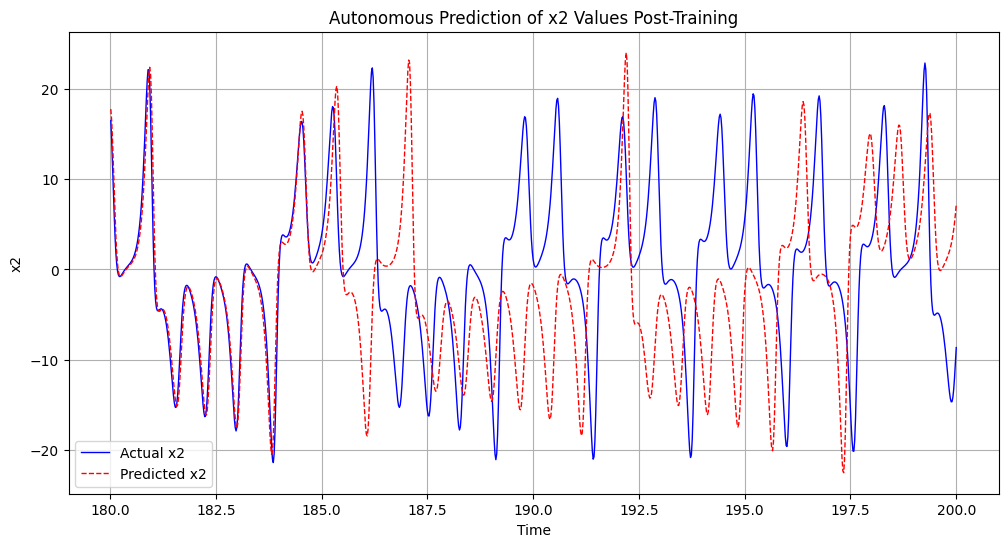

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from numpy import tanh, random



# Define training and prediction intervals
train_size = int(len(x2) * 0.9)  # Use 80% for training
test_size = len(x2) - train_size  # Remaining for testing

# Parameters for the reservoir
num_neurons = 500
input_scaling = 0.1
reservoir_scaling = 0.95

# Initialize weights
input_weights = random.randn(num_neurons, 1) * input_scaling
reservoir_weights = random.randn(num_neurons, num_neurons)
reservoir_weights *= reservoir_scaling / max(abs(np.linalg.eigvals(reservoir_weights)))

# Reservoir state initialization
reservoir_states = np.zeros((num_neurons, len(x2)))

# Train the reservoir on the training data
for t in range(1, train_size):
    input_term = np.dot(input_weights, x2[t-1]).flatten()
    reservoir_term = np.dot(reservoir_weights, reservoir_states[:, t-1])
    reservoir_states[:, t] = tanh(reservoir_term + input_term)

# Fit the output weights using ridge regression
output_weights = Ridge(alpha=1e-5).fit(reservoir_states[:, :train_size].T, x2[:train_size]).coef_

# Predict using trained weights
predicted = np.zeros(test_size)
reservoir_states_test = reservoir_states[:, train_size-1]  # Initial state for prediction

# The initial predicted value should ideally come from the model based on the last training state
predicted[0] = np.dot(output_weights, reservoir_states_test)

for i in range(1, test_size):
    input_term = np.dot(input_weights, predicted[i-1]).flatten()  # use last predicted value
    reservoir_term = np.dot(reservoir_weights, reservoir_states_test)
    reservoir_states_test = tanh(reservoir_term + input_term)
    predicted[i] = np.dot(output_weights, reservoir_states_test)

# Plot results with corrected predictions
plt.figure(figsize=(12, 6))
plt.plot(t_eval[train_size:train_size + test_size], x2[train_size:train_size + test_size], label='Actual x2', color='blue', linewidth=1)
plt.plot(t_eval[train_size:train_size + test_size], predicted, label='Predicted x2', color='red', linestyle='--', linewidth=1)
plt.title('Autonomous Prediction of x2 Values Post-Training')
plt.xlabel('Time')
plt.ylabel('x2')
plt.legend()
plt.grid(True)
plt.show()
